# 与信問題
## エラーもそのままにしています

# まとめ２
前回、グラフ化して、特徴が分かりやすい４変数を抜き出した  
key_param=['DAYS_BIRTH', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']
欠損値は平均で埋めた（EXT_SOURCEの意味が分からないため根拠なし）
　
正規化してロジスティック回帰
→ AUC = 0.71 （今回の最高値でKaggleにup） 　
　
SVC、RFなども試したが、ハイパーパラメータチューニングはしておらず（時間がかかる）、AUC値は上がらなかった。

In [1]:
import numpy as np #行列
import pandas as pd #データ分析
import matplotlib.pyplot as plt
import seaborn as sns #matplotlibを使いやすくしたもの
%matplotlib inline

import pandas_profiling as pdp #pandas report

# pdp.ProfileReport(df)  #分析してくれる

import cv2

In [2]:
df=pd.read_csv('input/application_train.csv')

In [3]:
df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


## 【問題1】コンペティション内容の確認
コンペティションのOverviewページ読み、「Home Credit Default Risk」について以下の観点について確認してください。  
 
何を学習し、何を予測するのか： 貸し倒れするかどうかを学習し、予測する  
どのようなファイルを作りKaggleに提出するか CSV file (ID, probability)  
提出されたものはどういった指標値で評価されるのか ROC  

# 【問題2】学習と検証
データを簡単に分析、前処理し、学習、検証するまでの一連の流れを作成・実行してください。  

検証にはこのコンペティションで使用される評価指標を用いるようにしてください。学習に用いる手法は指定しません。

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


In [5]:
df.describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,...,307511.000000,307511.000000,307511.000000,307511.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
mean,278180.518577,0.080729,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067,63815.045904,...,0.008130,0.000595,0.000507,0.000335,0.006402,0.007000,0.034362,0.267395,0.265474,1.899974
std,102790.175348,0.272419,0.722121,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,0.013831,4363.988632,141275.766519,...,0.089798,0.024387,0.022518,0.018299,0.083849,0.110757,0.204685,0.916002,0.794056,1.869295
min,100002.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-25229.000000,-17912.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189145.500000,0.000000,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,0.010006,-19682.000000,-2760.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,278202.000000,0.000000,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,0.018850,-15750.000000,-1213.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,367142.500000,0.000000,1.000000,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,0.028663,-12413.000000,-289.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,456255.000000,1.000000,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,0.072508,-7489.000000,365243.000000,...,1.000000,1.000000,1.000000,1.000000,4.000000,9.000000,8.000000,27.000000,261.000000,25.000000


In [6]:
df.isnull().sum()

SK_ID_CURR                        0
TARGET                            0
NAME_CONTRACT_TYPE                0
CODE_GENDER                       0
FLAG_OWN_CAR                      0
                              ...  
AMT_REQ_CREDIT_BUREAU_DAY     41519
AMT_REQ_CREDIT_BUREAU_WEEK    41519
AMT_REQ_CREDIT_BUREAU_MON     41519
AMT_REQ_CREDIT_BUREAU_QRT     41519
AMT_REQ_CREDIT_BUREAU_YEAR    41519
Length: 122, dtype: int64

In [7]:
# numpy and pandas for data manipulation
import numpy as np
import pandas as pd 

# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder

# File system manangement
import os

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
df.columns

Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY',
       ...
       'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20',
       'FLAG_DOCUMENT_21', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object', length=122)

In [19]:
df1=df

In [20]:
y = df['TARGET']

In [21]:
len(y)

307511

In [22]:
key_param=['DAYS_BIRTH', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']

In [23]:
df1=df[key_param]

In [24]:
df1.head()

,DAYS_BIRTH,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3
0,-9461,0.083037,0.262949,0.139376
1,-16765,0.311267,0.622246,NaN
2,-19046,NaN,0.555912,0.729567
3,-19005,NaN,0.650442,NaN
4,-19932,NaN,0.322738,NaN


In [25]:
df1.isnull().sum()

DAYS_BIRTH           0
EXT_SOURCE_1    173378
EXT_SOURCE_2       660
EXT_SOURCE_3     60965
dtype: int64

In [26]:
X = df1.fillna(df1.mean())

In [27]:
y = y.values

In [28]:
X = X.values

In [29]:
len(X)

307511

In [30]:
len(y)

307511

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0) # 50%のデータを学習データに、50%を検証データにする

scaler = StandardScaler()
scaler.fit(X_train)
X_train_transform = scaler.transform(X_train)
X_test_transform = scaler.transform(X_test)

lr = LogisticRegression() # ロジスティック回帰モデルのインスタンスを作成
lr.fit(X_train_transform, y_train) # ロジスティック回帰モデルの重みを学習

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [32]:
probs = lr.predict_proba(X_test_transform)
print(probs)

[[0.7235304  0.2764696 ]
 [0.97719368 0.02280632]
 [0.84014758 0.15985242]
 ...
 [0.96587733 0.03412267]
 [0.92739264 0.07260736]
 [0.91793226 0.08206774]]


In [33]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

In [34]:
fpr, tpr, thresholds = roc_curve(y_test, probs[:, 1])

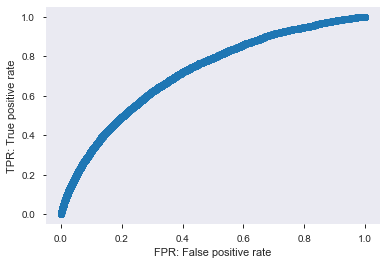

In [35]:
plt.plot(fpr, tpr, marker='o')
plt.xlabel('FPR: False positive rate')
plt.ylabel('TPR: True positive rate')
plt.grid()

In [36]:
from sklearn.metrics import roc_auc_score
import numpy as np

print(roc_auc_score(y_test, probs[:, 1]))

0.7177612963485203


In [37]:
df_test=pd.read_csv('input/application_test.csv')

In [38]:
df_test.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [39]:
K = df_test[key_param]

In [40]:
K.head()

,DAYS_BIRTH,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3
0,-19241,0.752614,0.789654,0.159520
1,-18064,0.564990,0.291656,0.432962
2,-20038,NaN,0.699787,0.610991
3,-13976,0.525734,0.509677,0.612704
4,-13040,0.202145,0.425687,NaN


In [31]:
K=K.fillna(K.mean())

In [32]:
K.head()

,DAYS_BIRTH,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3
0,-19241,0.752614,0.789654,0.159520
1,-18064,0.564990,0.291656,0.432962
2,-20038,0.501180,0.699787,0.610991
3,-13976,0.525734,0.509677,0.612704
4,-13040,0.202145,0.425687,0.500106


In [33]:
K_transform = scaler.transform(K)

In [34]:
probs = lr.predict_proba(K_transform)
print(probs)

[[0.94545404 0.05454596]
 [0.88813472 0.11186528]
 [0.96988045 0.03011955]
 ...
 [0.93845656 0.06154344]
 [0.92472512 0.07527488]
 [0.8654897  0.1345103 ]]


In [35]:
KK = probs[:, 1]

In [36]:
KK

array([0.05454596, 0.11186528, 0.03011955, ..., 0.06154344, 0.07527488,
       0.1345103 ])

In [43]:
#np.savetxt('result_2.csv',KK,delimiter=',')

In [41]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

In [42]:
lr_predict = lr.predict(X_test_transform)

In [43]:
lr_predict

array([0, 0, 0, ..., 0, 0, 0])

In [44]:
accuracy_score(y_test, lr_predict )

0.920833130091215

In [45]:
precision_score(y_test, lr_predict )

0.375

In [46]:
recall_score(y_test, lr_predict )

0.004325437693099897

In [47]:
f1_score(y_test, lr_predict )

0.00855222968845449

In [48]:
confusion_matrix(y_test,lr_predict )

array([[56613,    35],
       [ 4834,    21]])

In [45]:
from sklearn.ensemble import RandomForestClassifier
rfc=RandomForestClassifier()
rfc.fit(X_train_transform, y_train) 

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [46]:
probs = rfc.predict_proba(X_test_transform)
print(probs)

[[0.3 0.7]
 [1.  0. ]
 [0.9 0.1]
 ...
 [1.  0. ]
 [1.  0. ]
 [0.8 0.2]]


In [60]:
fpr, tpr, thresholds = roc_curve(y_test, probs[:, 1])

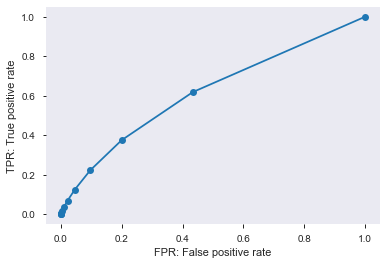

In [61]:
plt.plot(fpr, tpr, marker='o')
plt.xlabel('FPR: False positive rate')
plt.ylabel('TPR: True positive rate')
plt.grid()

In [62]:
print(roc_auc_score(y_test, probs[:, 1]))

0.6174538163731695


In [ ]:
from sklearn.svm import SVC
svc = SVC()
svc.fit(X_train_transform, y_train) 

In [ ]:
probs = svc.predict_proba(X_test_transform)
print(probs)

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, probs[:, 1])
plt.plot(fpr, tpr, marker='o')
plt.xlabel('FPR: False positive rate')
plt.ylabel('TPR: True positive rate')
plt.grid()

In [49]:
from sklearn.tree import DecisionTreeClassifier
dtc=DecisionTreeClassifier()
dtc.fit(X_train_transform, y_train) 

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [50]:
probs = dtc.predict_proba(X_test_transform)
print(probs)

[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]


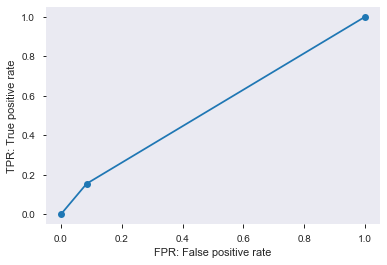

In [51]:
fpr, tpr, thresholds = roc_curve(y_test, probs[:, 1])
plt.plot(fpr, tpr, marker='o')
plt.xlabel('FPR: False positive rate')
plt.ylabel('TPR: True positive rate')
plt.grid()

In [ ]:
print(roc_auc_score(y_test, probs[:, 1]))

In [52]:
from sklearn.neighbors import KNeighborsClassifier
nn = KNeighborsClassifier()
nn.fit(X_train_transform, y_train) 

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [53]:
probs = nn.predict_proba(X_test_transform)
print(probs)

[[0.6 0.4]
 [1.  0. ]
 [0.8 0.2]
 ...
 [0.8 0.2]
 [1.  0. ]
 [1.  0. ]]


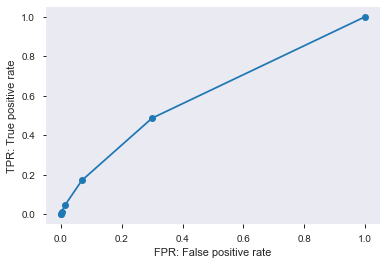

In [54]:
fpr, tpr, thresholds = roc_curve(y_test, probs[:, 1])
plt.plot(fpr, tpr, marker='o')
plt.xlabel('FPR: False positive rate')
plt.ylabel('TPR: True positive rate')
plt.grid()

In [ ]:
print(roc_auc_score(y_test, probs[:, 1]))

In [47]:
from sklearn.model_selection import GridSearchCV

In [48]:
parameters = {
    "n_estimators":[i for i in range(10,100,10)],
    "criterion":["gini","entropy"],
    "max_depth":[i for i in range(1,6,1)],
     'min_samples_split': [2, 4, 10,12,16],
    "random_state":[3],
}
#scorer = make_scorer(fbeta_score, beta=0.5)

In [ ]:
#モデルを作成
clf = GridSearchCV(RandomForestClassifier(), parameters,cv=5,n_jobs=-1)
clf_fit=clf.fit(X_train_transform, y_train)
#最も良い学習モデルで学習
predictor=clf_fit.best_estimator_